<a href="https://colab.research.google.com/github/KESHAVBERG/detections/blob/main/CannyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.image as mpimg
import os
import scipy.misc as sm
import skimage
from scipy import ndimage
from  skimage.feature import canny
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import convolve

from scipy import misc

In [2]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [3]:
def imgLoad(dirName = "imgs"):
  imgList = []
  for fn in os.listdir(dirName):
    img = mpimg.imread(dirName +"/"+ fn)
    img = rgb2gray(img)
    imgList.append(img)
  return imgList  

In [4]:
load_data = imgLoad()

In [5]:
for i in load_data:
  print(i.shape)

(1280, 1920)
(1280, 1920)
(1280, 1920)


In [6]:
def visualize(imgs, format=None):
  plt.figure(figsize=(20,40))
  for i , img in enumerate(imgs):
    if img.shape[0] == 3:
      img = img.transpose(1,2,0)
    plt_index = i + 1
    plt.subplot(4,2,plt_index)
    plt.imshow(img,cmap='gray', vmin=0, vmax=255)
  plt.show()    


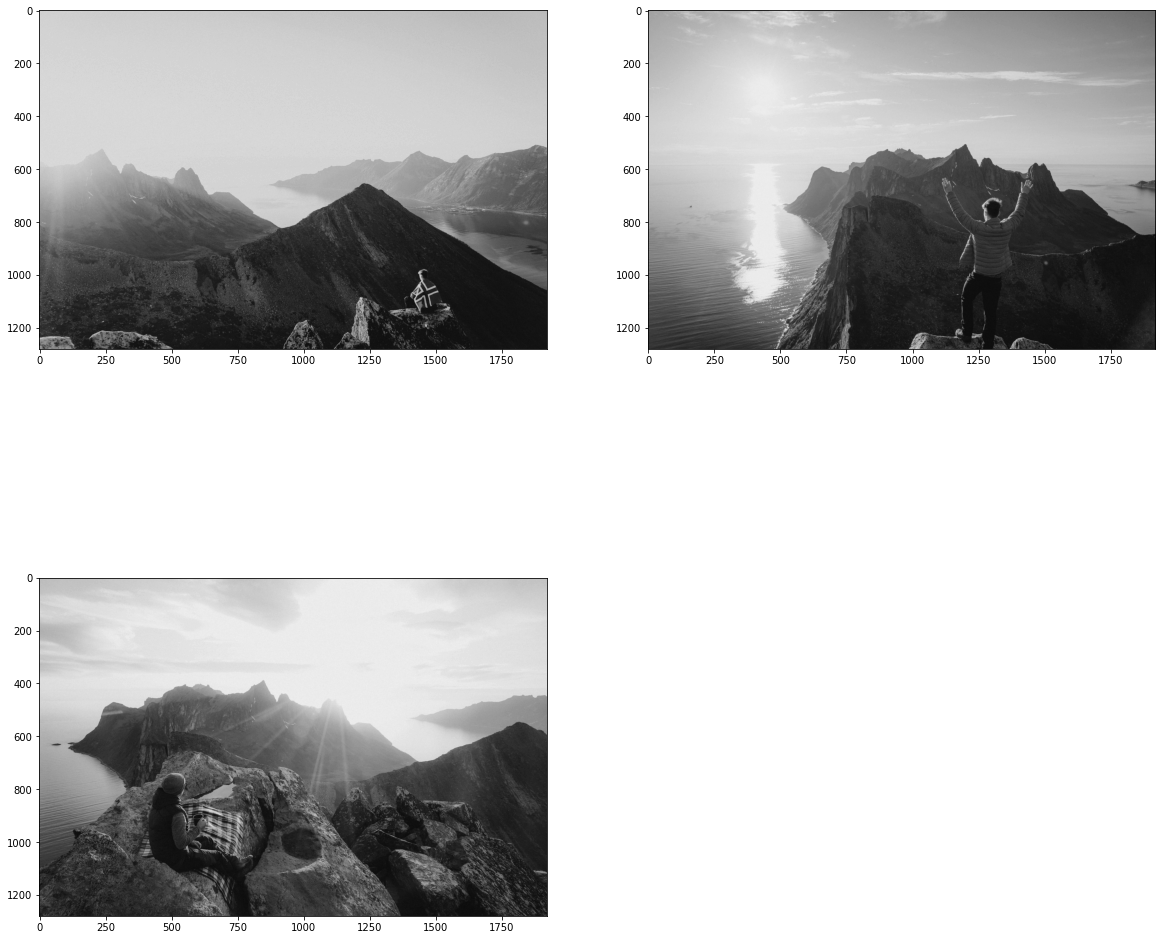

In [7]:
visualize(load_data)

Noise from the image is removed and the image is sommthend using Gaussian blur.


---


**Kernal Size** = 5 * 5

**sigma** = 1.4

Sum of elements in the Kernal = 1, therfore the kernal should be normalized before convolution. 


In [8]:
def gaussian_kernel(size,sigma=1):
  size = int(size)//2
  x,y = np.mgrid[-size:size+1,-size:size+1]
  normal  = 1/(2.0*np.pi*sigma**2)
  g = np.exp(-((x**2 + y**2/(2.0*np.pi*sigma**2))))*normal
  return g

To calculate the gradient we take somothed Image I different it w.r.t to x and y. It can be implemented bt convolving Image with sobel kernels Screenshot 2021-02-04 153718.png

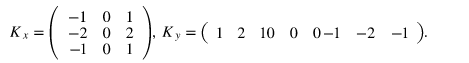

The magnitude G and the slope theta is calculated 

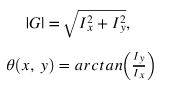

In [9]:
def sobel_filters(img):

  Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
  Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

  Ix = ndimage.filters.convolve(img, Kx)
  Iy = ndimage.filters.convolve(img, Ky)
  
  G = np.hypot(Ix, Iy)  
  G = G/G.max()*255
  
  theta = np.arctan2(Iy,Ix)

  return G, theta

**Non-maximum suppression**. For each pixel find two neighbors (in the positive and negative gradient directions, supposing that each neighbor occupies the angle of $\pi /4$, and $0$ is the direction straight to the right). If the magnitude of the current pixel is greater than the magnitudes of the neighbors, nothing changes, otherwise, the magnitude of the current pixel is set to zero.

In [16]:
def non_max_suppression(img, D):
  M,N = img.shape
  z = np.zeros((M,N))
  angle = D*180/np.pi
  angle[angle<0] += 180
  for i in range(1,M-1):
    for j in range(1, N-1):
      try:
        q = 255
        r = 255 
        if (0<= angle[i,j]<22.5)or(157.5 <= angle[i,j]<= 180):
          r = img[i, j - 1]
          q = img[i, j + 1]
        elif (22.5 <= angle[i,j] < 67.5):
          q = img[i + 1, j - 1]
          r = img[i - 1, j + 1]
        elif (67.5 <= angle[i,j] < 112.5):
          q = img[i + 1 , j]
          r = img[i - 1 , j]
        elif (112.5 <= angle[i,j] < 157.5):
          q = img[i - 1, j - 1]
          r = img[i + 1, j + 1]
        if (img[i,j] >= q) and (img[i,j] >= r):
          z[i,j] = img[i,j]
        else:
          z[i,j] = 0 
      except IndexError as e:
        pass
  return z



In [17]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)



In [18]:
def hysteresis(img, weak, strong = 255):
  M , N = img.shape
  for i in range(1,M-1):
    for j in range(1,N - 1):
      if (img[i,j] == weak):
        try:
          if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
            img[i , j] == strong 
          else:
            img[i,j] = 0
        except IndexError  as e:
          pass
  return img
            

In [21]:
def cannyDetector(img):
  img_filtered  = convolve(img, gaussian_kernel(5, sigma=1.4))
  grad, theta = sobel_filters(img_filtered)
  img_nms = non_max_suppression(grad, theta)
  img_thresh, weak, strong = threshold(img_nms, lowThresholdRatio=0.07,highThresholdRatio=0.09)
  img_final = hysteresis(img_thresh, weak=weak, strong=strong)
  return img_final

Processing image 1
Processing image 2
Processing image 3


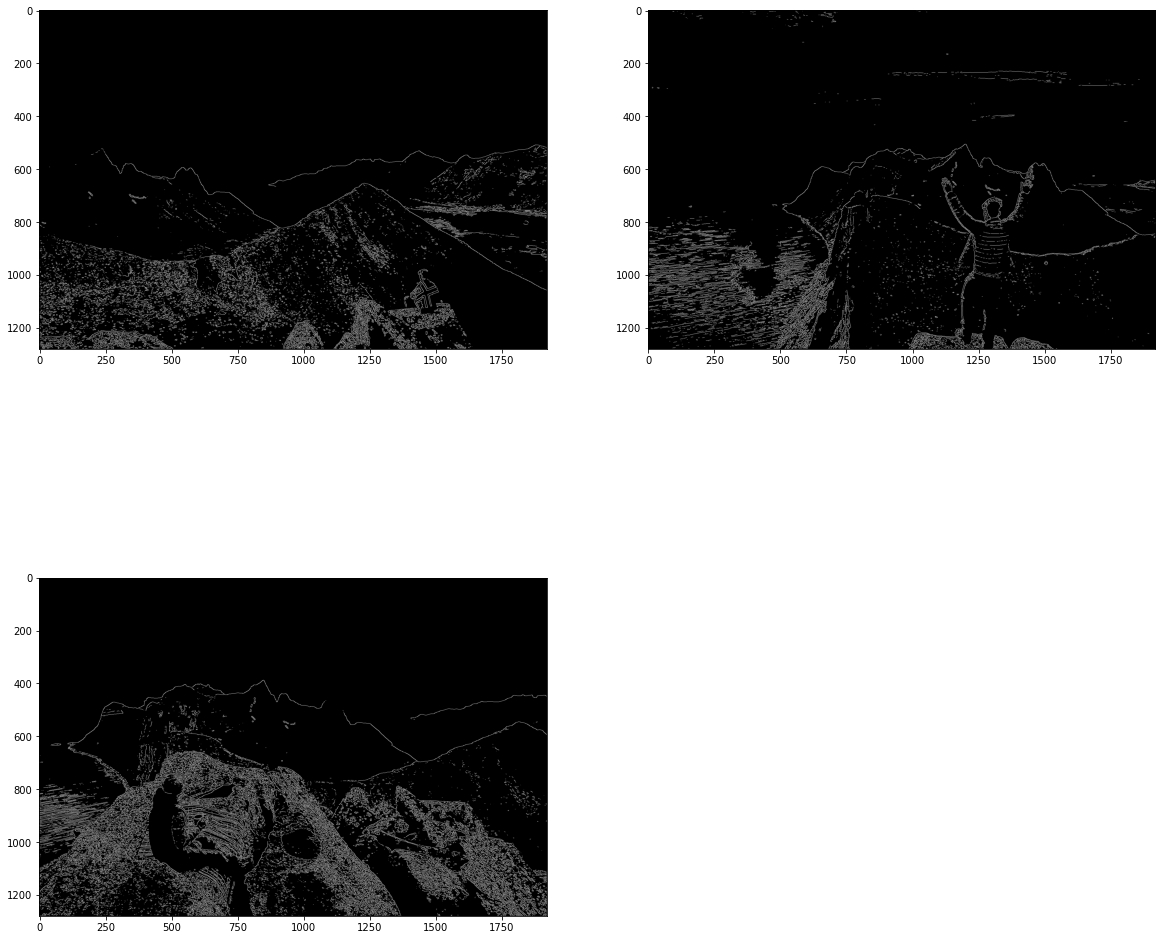

In [22]:
canny_imgs = []
for i, img in enumerate(load_data):
    print("Processing image %i" % (i+1))
    canny_img = cannyDetector(img)
    canny_imgs.append(canny_img)
    
visualize(canny_imgs, 'gray')